The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Gráfico salvo como 'Images/WindSpeed.eps'


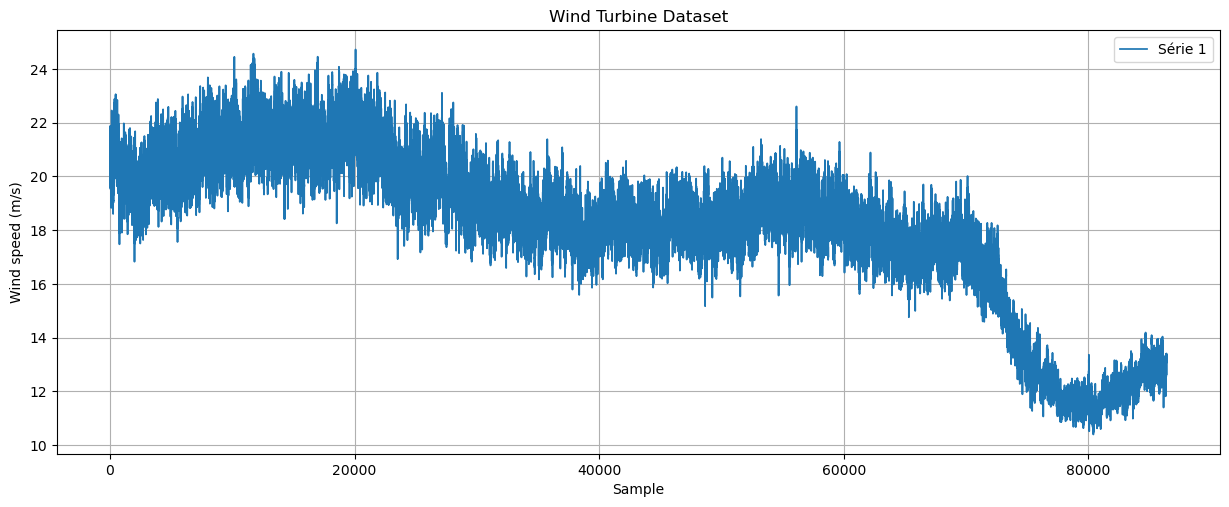

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy.integrate import solve_ivp
from scipy.signal import cont2discrete, tf2ss
import math
from _GraphUtils import *

params = {
    
    'ALPHA' : 0.1,
    'ALPHA_gc' : 50,
    'Area' :  math.pi * (57.5**2),
    'B_dt' : 755.49,
    'B_r' : 7.11,
    'B_g' : 45.6,
    'Cp_max' : 0.486,
    'D_max' : 1000,
    'ETA_dt' : 0.97,
    'ETA_gc' : 0.98,
    'f_s': 0.01,
    'H' : 81,
    'J_r' : 55*1e6,
    'J_g' : 390,
    'K_dt' : 2.7*1e9,
    'K_opt' : 1.2171,
    'k_i' : 1,
    'k_p' : 4,
    'LAMBDA_opt' : 7.6,
    'N_g' : 95,
    'OMEGA_n' : 11.11,
    'OMEGA_nom' : 162,
    'OMEGA_var' : 15,
    'PI' : np.pi,
    'PHI_opt' : 0,
    'P_r' : 4.8*1e6,
    'r_0' : 1.5,
    'R' : 57.5,
    'RHO' : 1.225,
    'T_s' : 0.01,
    'ZETA' : 0.6,

}

def Cp_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'TSRxCPxPSI.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

def Cq_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'Cq.csv'
    df = pd.read_csv(path)
    angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

path = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4*1.5

PlotSeries(y_arrays=[v[:]],w=15,h=5.5,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False, file_name=r'Images/WindSpeed.eps',save=True,lw=1.25)

In [52]:


class HAWT:
    def __init__(self, **params):

        self.Area =params['Area']
        self.ALPHA_gc = params['ALPHA_gc']
        self.B_dt =params['B_dt']
        self.B_r =params['B_r']
        self.B_g =params['B_g']
        self.Cp_max =params['Cp_max']
        self.ETA_dt =params['ETA_dt']
        self.ETA_gc =params['ETA_gc']
        self.f_s =params['f_s']
        self.J_r =params['J_r']
        self.J_g =params['J_g']
        self.K_dt =params['K_dt']
        self.K_opt =params['K_opt']
        self.k_i =params['k_i']
        self.k_p =params['k_p']
        self.LAMBDA_opt =params['LAMBDA_opt']
        self.N_g =params['N_g']
        self.OMEGA_n =params['OMEGA_n']
        self.OMEGA_nom =params['OMEGA_nom']
        self.OMEGA_var =params['OMEGA_var']
        self.PHI_opt = params['PHI_opt']
        self.P_r =params['P_r']
        self.PI =params['PI']
        self.R =params['R']
        self.RHO =params['RHO']
        self.T_s = params['T_s']
        self.ZETA = params['ZETA']
        
        self.X  = np.array([0,0,0,0])
        self.X_ptich  = np.zeros((2, 1))
        self.dX = np.array([0,0,0,0,0]) 
        self.dX_ptich  = np.zeros((2, 1))
        self.e = np.array([0])
        self.PHI_ref = np.array([0])   
        self.PHI_m = np.array([0])   
        self.P_g = np.array([])  
        self.P_d = np.array([]) 
        self.OMEGA_g = np.array([])  
        self.mode = np.array([])     
        self.ctrl_mode = 'mode1'
        self.U = None

        #PitchController
        num = [self.OMEGA_n**2]
        den = [1, 2*self.ZETA*self.OMEGA_n, self.OMEGA_n**2]
        self.Ap, self.Bp, self.Cp, self.Dp = tf2ss(num, den)

        #GeneratorConverterModel
        num = [self.ALPHA_gc]
        den = [1, self.ALPHA_gc]
        self.Ag, self.Bg, self.Cg, self.Dg = tf2ss(num, den)

    def set_state(self, X):
        self.X = X.flatten()

    def Calculate_TAU_r(self, OMEGA_r, v, PHI=0):
        
        LAMBDA = OMEGA_r*self.R/v
        C_q = Cq_calc(LAMBDA, PHI)
        TAU = self.RHO*self.PI*(self.R**3)*C_q*(v**2)/(2)
        return TAU

    def Calculate_TAU_gr(self, OMEGA_g, u_k=0, PHI=0):
        
        LAMBDA = self.LAMBDA_opt+u_k
        C_p = Cp_calc(LAMBDA,PHI)
        K_mppt = 0.5*self.RHO*self.Area*(self.R**3)*C_p/(LAMBDA**3)
        TAU_gr = K_mppt*(OMEGA_g**2)/(self.N_g**2)
        P_g = self.ETA_gc*OMEGA_g*TAU_gr

        if P_g >= self.P_r or OMEGA_g >= self.OMEGA_nom:
            self.ctrl_mode = 'mode2'
        if OMEGA_g < self.OMEGA_nom - self.OMEGA_var:
            self.ctrl_mode = 'mode1'

        if self.ctrl_mode == 'mode1':
            self.mode = np.append(self.mode,1)
            self.K_mppt = K_mppt
            self.TAU_gr = TAU_gr
            self.PHI_ref = np.append(self.PHI_ref, 0)
            self.PHI_m = np.append(self.PHI_m, 0)

        if self.ctrl_mode == 'mode2':
            self.mode = np.append(self.mode,2)
            TAU_gr = self.P_r/(self.ETA_gc*OMEGA_g)
            e = OMEGA_g - self.OMEGA_nom
            PHI_ref = self.PHI_ref[-1] + self.k_p*e + (self.k_i*self.T_s - self.k_p)*self.e[-1]
            self.e = np.append(self.e, e)
            self.PHI_ref = np.append(self.PHI_ref, PHI_ref)

        return TAU_gr, self.PHI_ref[-1]

    def dynamics(self, t, X, U):

        A11 = -(self.B_dt+self.B_r)/self.J_r
        A12 = self.B_dt/(self.N_g*self.J_r)
        A13 = -self.K_dt/self.J_r
        A21 = (self.B_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A22 = -(((self.B_dt*self.ETA_dt)/(self.N_g**2))+self.B_g)*(1/self.J_g)
        A23 = (self.K_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A32 = -1/self.N_g
        A54 = -(self.OMEGA_n**2)
        A55 = -(2*self.ZETA*self.OMEGA_n)
        
        B11 = 1/self.J_r
        B22 = -1/self.J_g
        B53 = (self.OMEGA_n**2)
        
        A = np.array([[A11, A12, A13,   0,   0],
                      [A21, A22, A23,   0,   0],
                      [  1, A32,   0,   0,   0],
                      [  0,   0,   0,   0,   1],
                      [  0,   0,   0, A54, A55]])
        
        B = np.array([[B11,   0,   0],
                      [  0, B22,   0],
                      [  0,   0,   0],
                      [  0,   0,   0],
                      [  0,   0, B53]])

        dX = (A@X.reshape(-1,1))+(B@U.reshape(-1,1))
        self.dX = dX.flatten()
        return dX.flatten()
    
    def compute_input(self, X, v, u_k=0):
        
        OMEGA_r, OMEGA_g = X[0], X[1]
        TAU_r = self.Calculate_TAU_r(OMEGA_r, v, PHI=self.PHI_m[-1])
        TAU_g, PHI_ref = self.Calculate_TAU_gr(OMEGA_g, u_k, PHI=self.PHI_ref[-1])
        du = np.array([TAU_r,TAU_g,PHI_ref])
        self.U = du
        
        return du
    
    def iterate(self, u, dt):
        #DOP853
        sol = solve_ivp(self.dynamics, [0, dt], self.X, 
            args=(u.flatten(),), method="RK23", t_eval=[dt])
        self.X = sol.y[:, -1]
        return self.X
    
    def compute_output(self):
        X = self.X.reshape(1,-1)
        dX = self.dX.reshape(1,-1)
        TAU_r, TAU_g, PHI_ref = self.U
        OMEGA_r, OMEGA_g,THETA, PHI_m, dPHI_m = self.X

        P_g = TAU_g*OMEGA_g*self.ETA_gc
        P_d = self.B_dt*((OMEGA_r-OMEGA_g)**2)
        self.P_g = np.append(self.P_g,P_g)
        self.P_d = np.append(self.P_d,P_d)
        self.OMEGA_g = np.append(self.OMEGA_g,OMEGA_g)
        self.PHI_m = np.append(self.PHI_m, PHI_m)




In [58]:
hawt = HAWT(**params)
X=np.array([0.1, 0.1, 0, 0, 0])
hawt.set_state(X)
i=0

In [ ]:
print(hawt.X)
U = hawt.compute_input(X,v=v[i],u_k=0)
X = hawt.iterate(U,0.001)
hawt.compute_output()
print(hawt.X)
i=i+1

[9.82004452e-02 6.24388029e+00 1.41616190e-03 0.00000000e+00
 0.00000000e+00]
[9.77734988e-02 7.19187527e+00 1.69063338e-03 0.00000000e+00
 0.00000000e+00]


In [94]:
hawt = HAWT(**params)
X=np.array([0.1,0.1,0,0,0])

hawt.set_state(X)

e = 10000
for i,v_ in enumerate(v[:e]):
    print(i,'/',len(v))
    #if i%5==0: clear_output(wait=False)
    U = hawt.compute_input(X,v=v_,u_k=0)
    X = hawt.iterate(U,0.01)
    hawt.compute_output()

0 / 86400
1 / 86400
2 / 86400
3 / 86400
4 / 86400
5 / 86400
6 / 86400
7 / 86400
8 / 86400
9 / 86400
10 / 86400
11 / 86400
12 / 86400
13 / 86400
14 / 86400
15 / 86400
16 / 86400
17 / 86400
18 / 86400
19 / 86400
20 / 86400
21 / 86400
22 / 86400
23 / 86400
24 / 86400
25 / 86400
26 / 86400
27 / 86400
28 / 86400
29 / 86400
30 / 86400
31 / 86400
32 / 86400
33 / 86400
34 / 86400
35 / 86400
36 / 86400
37 / 86400
38 / 86400
39 / 86400
40 / 86400
41 / 86400
42 / 86400
43 / 86400
44 / 86400
45 / 86400
46 / 86400
47 / 86400
48 / 86400
49 / 86400
50 / 86400
51 / 86400
52 / 86400
53 / 86400
54 / 86400
55 / 86400
56 / 86400
57 / 86400
58 / 86400
59 / 86400
60 / 86400
61 / 86400
62 / 86400
63 / 86400
64 / 86400
65 / 86400
66 / 86400
67 / 86400
68 / 86400
69 / 86400
70 / 86400
71 / 86400
72 / 86400
73 / 86400
74 / 86400
75 / 86400
76 / 86400
77 / 86400
78 / 86400
79 / 86400
80 / 86400
81 / 86400
82 / 86400
83 / 86400
84 / 86400
85 / 86400
86 / 86400
87 / 86400
88 / 86400
89 / 86400
90 / 86400
91 / 8640

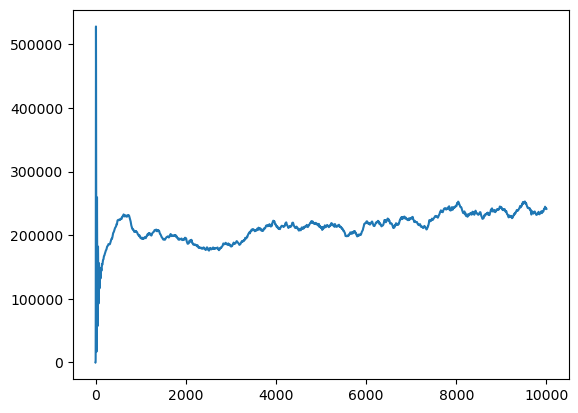

In [95]:
y = hawt.P_g[:]
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

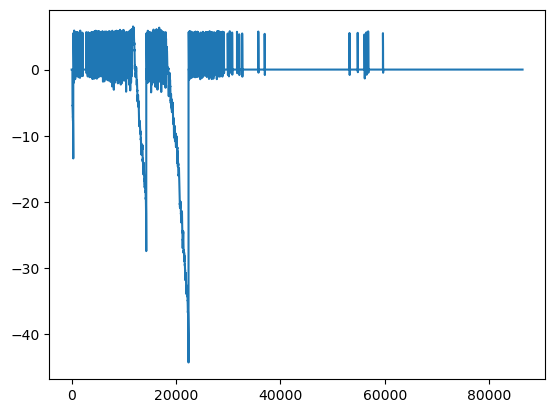

In [ ]:
y = hawt.PHI_m
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])

plt.plot(x,y)

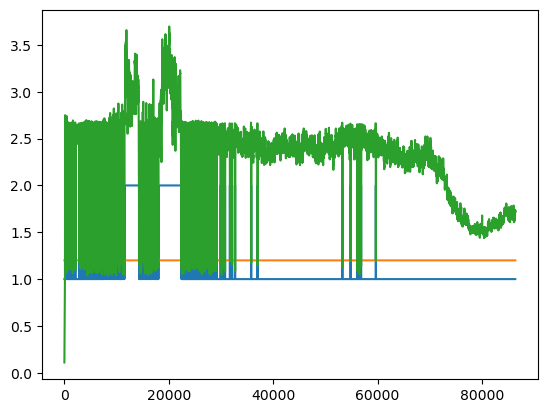

In [ ]:
y = hawt.OMEGA_g
x = np.arange(len(y))
y2 = np.array([hawt.OMEGA_nom-hawt.OMEGA_var for i in range(len(x))])
#y3 = np.array([hawt.mode for i in range(len(x))])
plt.plot(x,hawt.mode)
plt.plot(x,y2)
plt.plot(x,y)

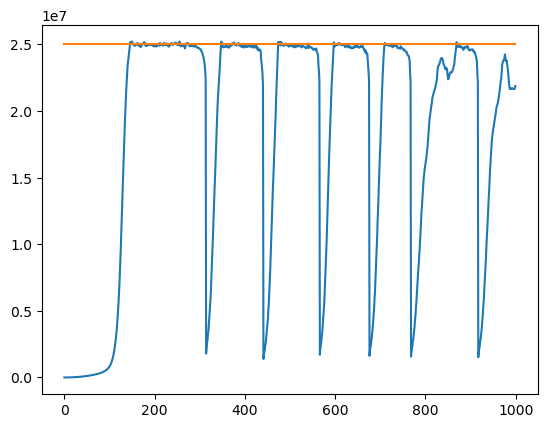

In [ ]:
y = hawt.P_g
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])
plt.plot(x,y)
plt.plot(x,y2)